# Analysis of EhV data using SCIP and IDEAS features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [4]:
import fcsparser
from ehv import feature_comparison, core
import flowutils
import shap
shap.initjs()

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from multiprocessing import Pool
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# Data import

In [147]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [7]:
data_dir = Path(os.environ["HOME"]) / "scratch/data/ehv"

In [10]:
df_scip = pq.read_table(data_dir / f"results/scip/202112021107_dapi/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load(data_dir / "results/scip/202112021107_dapi/columns.npy", allow_pickle=True)]
df_scip.shape

(133970, 760)

In [11]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(133970, 760)

In [12]:
df_scip = df_scip.drop(columns=df_scip.filter(regex="BF2$"))
df_scip.shape

(133970, 648)

In [13]:
# ideas features
tmp = []
for p in Path(data_dir / "results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [14]:
df_ideas = df_ideas.drop(columns=df_ideas.filter(regex=".*(mcp|ch4).*").columns)
df_ideas.shape

(144421, 157)

In [15]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])

In [16]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group", "meta_type"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(133354, 797)

In [17]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [18]:
df.head()

meta_bbox_minr  \
meta_object_number meta_replicate meta_group meta_type                   
7782               3              7          Ctrl                 18.0   
2771               3              7          Ctrl                 16.0   
11734              3              7          Ctrl                 25.0   
13700              3              7          Ctrl                 16.0   
14596              3              7          Ctrl                 16.0   

                                                        meta_bbox_minc  \
meta_object_number meta_replicate meta_group meta_type                   
7782               3              7          Ctrl                 10.0   
2771               3              7          Ctrl                 15.0   
11734              3              7          Ctrl                 12.0   
13700              3              7          Ctrl                  9.0   
14596              3              7          Ctrl                  7.0   

                                                        meta_bbox_maxr  \
meta_object_number meta_replicate meta_group meta_type                   
7782               3              7          Ctrl                 32.0   
2771               3              7          Ctrl                 32.0   
11734              3              7          Ctrl                 39.0   
13700              3              7          Ctrl                 30.0   
14596              3              7          Ctrl                 32.0   

                                                        meta_bbox_maxc  \
meta_object_number meta_replicate meta_group meta_type                   
7782               3              7          Ctrl                 25.0   
2771               3              7          Ctrl                 30.0   
11734              3              7          Ctrl                 26.0   
13700              3              7          Ctrl                 24.0   
14596              3              7          Ctrl                 23.0   

                                                        meta_regions_BF1  \
meta_object_number meta_replicate meta_group meta_type                     
7782               3              7          Ctrl                    1.0   
2771               3              7          Ctrl                    1.0   
11734              3              7          Ctrl                    2.0   
13700              3              7          Ctrl                    2.0   
14596              3              7          Ctrl                    2.0   

                                                        meta_regions_TMR  \
meta_object_number meta_replicate meta_group meta_type                     
7782               3              7          Ctrl                    1.0   
2771               3              7          Ctrl                    2.0   
11734              3              7          Ctrl                    2.0   
13700              3              7          Ctrl                    2.0   
14596              3              7          Ctrl                    1.0   

                                                        meta_regions_SSC  \
meta_object_number meta_replicate meta_group meta_type                     
7782               3              7          Ctrl                    2.0   
2771               3              7          Ctrl                    2.0   
11734              3              7          Ctrl                    2.0   
13700              3              7          Ctrl                    2.0   
14596              3              7          Ctrl                    1.0   

                                                        meta_regions_DAPI  \
meta_object_number meta_replicate meta_group meta_type                      
7782               3              7          Ctrl                     1.0   
2771               3              7          Ctrl                     1.0   
11734              3              7          Ctrl                     1.0

# Feature comparison between IDEAS and SCIP

## TMR

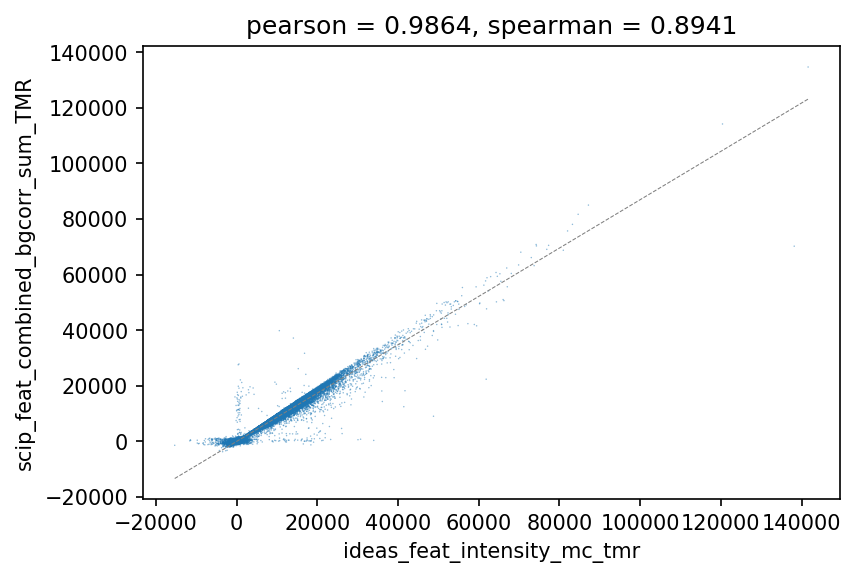

In [19]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_tmr", "scip_feat_combined_bgcorr_sum_TMR")

## Filter

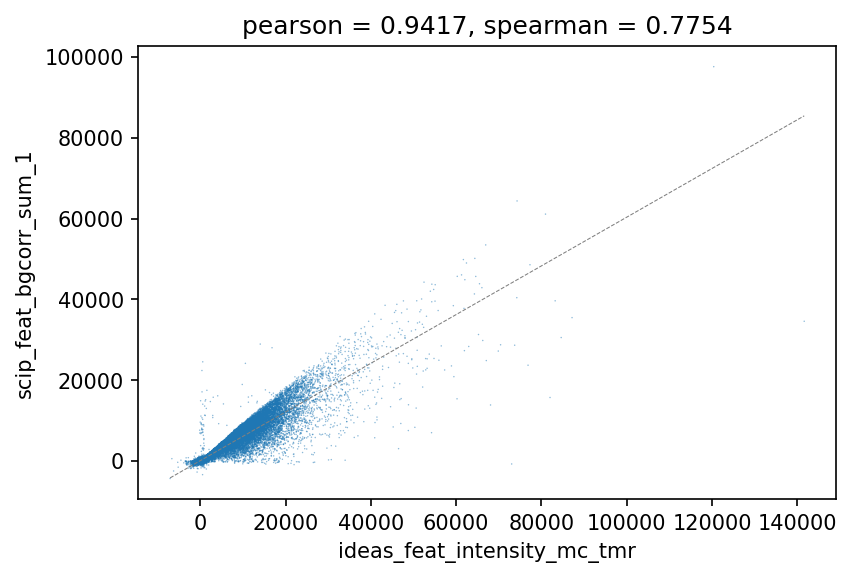

In [437]:
sel1 = df["scip_feat_bgcorr_sum_1"] == 0
sel2 = df["ideas_feat_intensity_mc_tmr"] != 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")

In [438]:
df = df[~(sel1 & sel2)]
df.shape

(92834, 472)

## BF

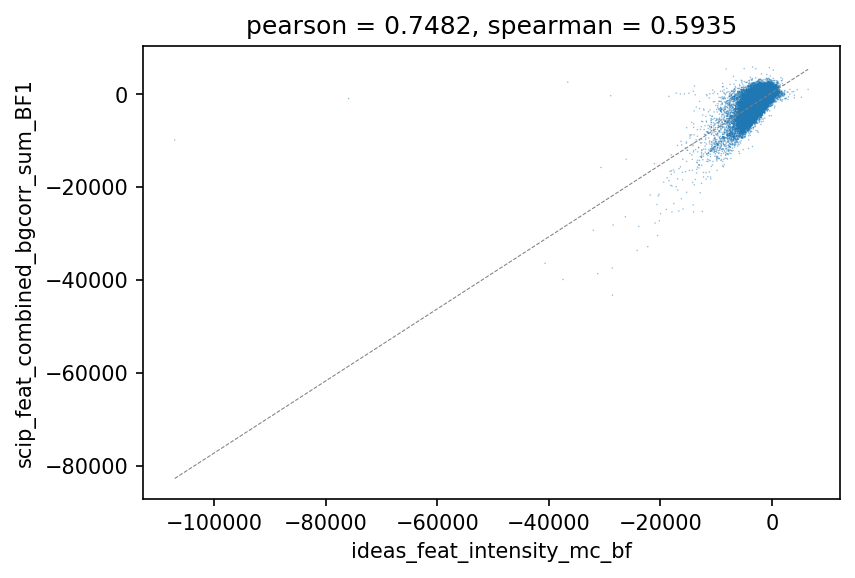

In [20]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_bf", "scip_feat_combined_bgcorr_sum_BF1")

### filter

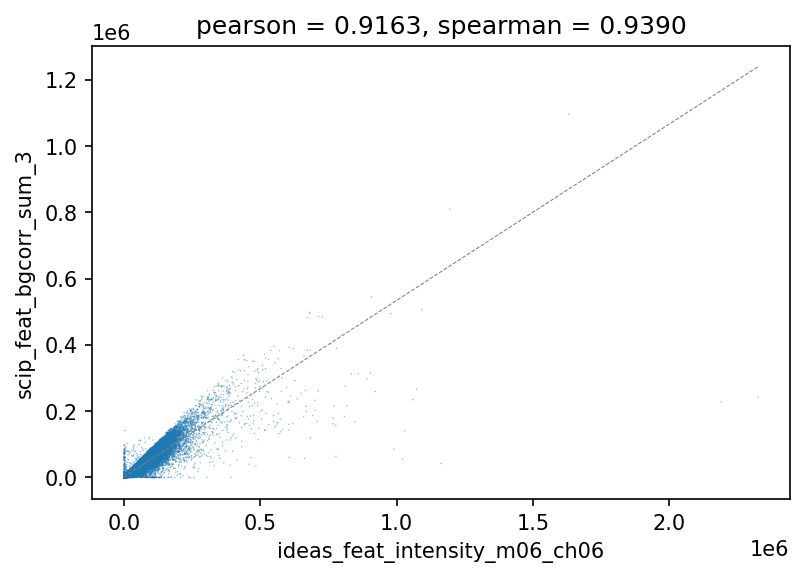

In [440]:
feature_comparison.compare_features(df, "ideas_feat_intensity_m06_ch06", "scip_feat_bgcorr_sum_3")

## DAPI

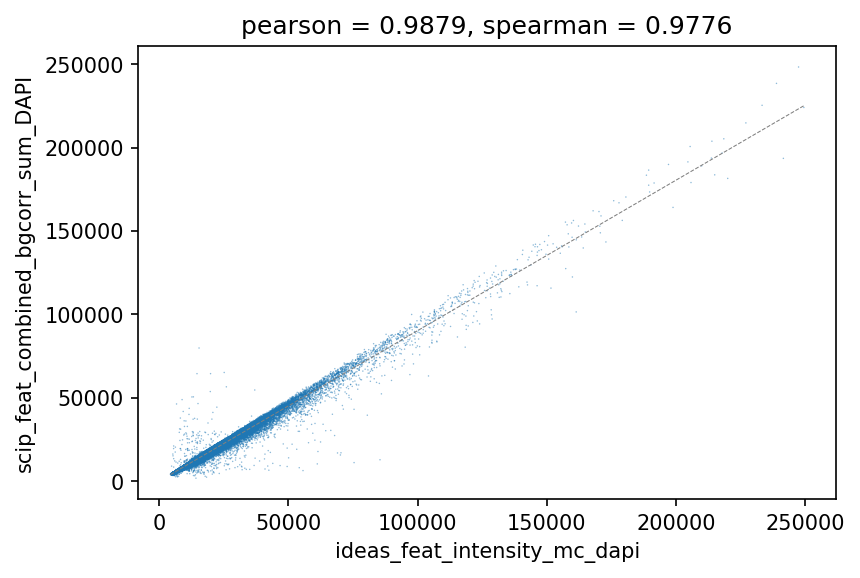

In [21]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_dapi", "scip_feat_combined_bgcorr_sum_DAPI")

### filter

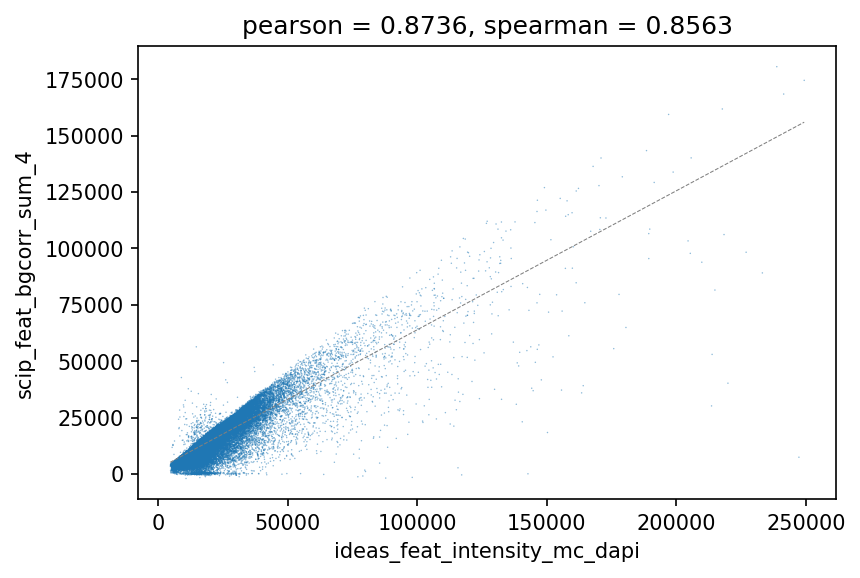

In [443]:
sel1 = df["ideas_feat_intensity_mc_dapi"] != 0
sel2 = df["scip_feat_bgcorr_sum_4"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")

In [444]:
df = df[~(sel1 & sel2)]
df.shape

(91862, 472)

## Cy5

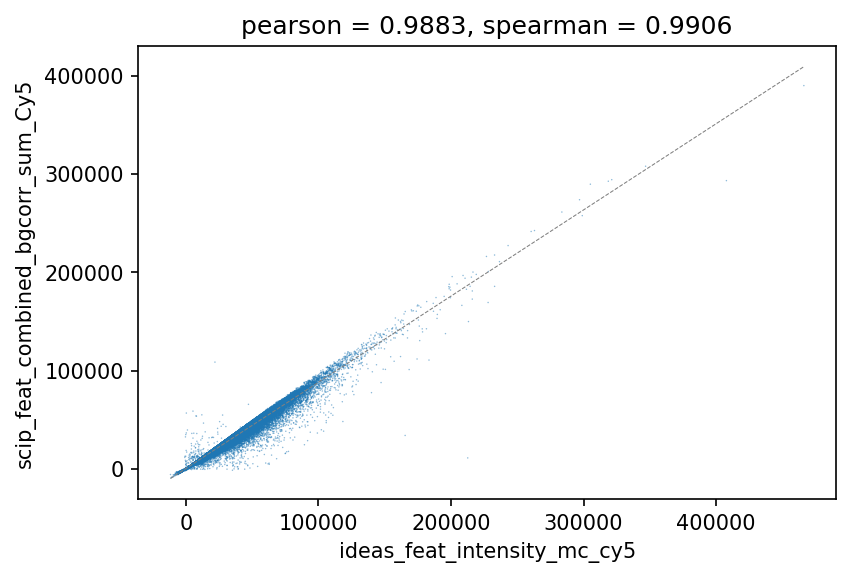

In [22]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_cy5", "scip_feat_combined_bgcorr_sum_Cy5")

### Filter

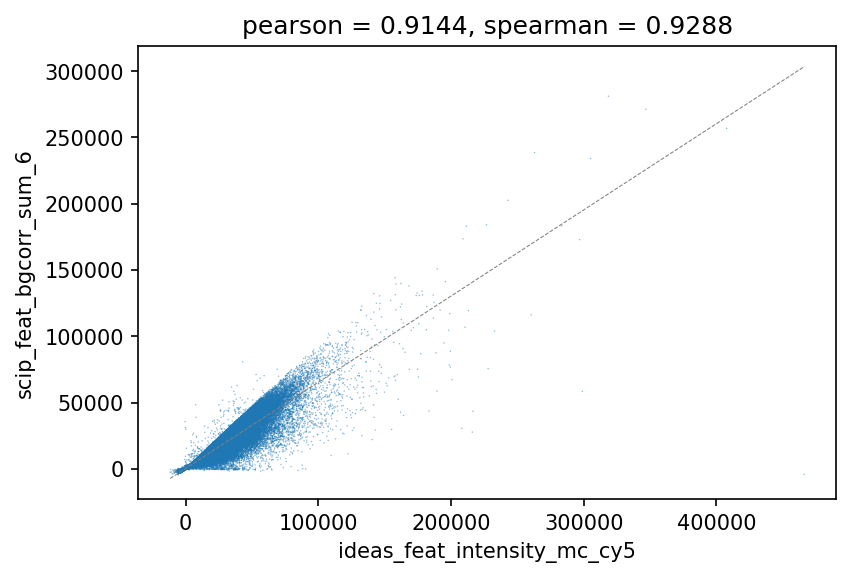

In [446]:
sel1 = df["ideas_feat_intensity_mc_cy5"] != 0
sel2 = df["scip_feat_bgcorr_sum_6"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_cy5", "scip_feat_bgcorr_sum_6")

In [447]:
df = df[~(sel1 & sel2)]
df.shape

(88194, 472)

# Continue with events assigned to cell states

Previously, unknown events falling between gates were also present.

In [23]:
df = df[df["meta_label"] != "unknown"]
df.shape

(129008, 797)

# Example images

In [25]:
import zarr
import skimage
from scipy.stats import truncnorm

In [26]:
paths = numpy.random.choice(df.loc[:,:,:,"Inf"]["meta_path"].unique(), size=10)
paths

array(['/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T7_R2.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T3_R2_32.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R1.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R2.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T4_R3.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R3_30.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R3_39.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T2_R3_39.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T5_R3_36.zarr',
       '/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/images/Inf_T9_R3.zarr'],
      dtype=object)

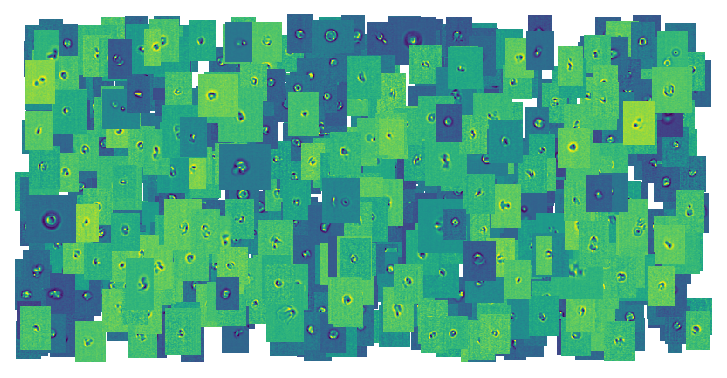

In [27]:
rows = df[df["meta_path"].isin(paths) & df["scip_feat_max_0"].between(740,750) & (df["scip_feat_area_0"] > 10)].sample(n=800)
cloud = numpy.zeros(shape=(400, 800, 4), dtype='float')
for path, gdf in rows.groupby("meta_path"):
    z = zarr.open(path)
    for idx, row in gdf.iterrows():
        img = numpy.clip(z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])[0], a_min=0, a_max=4096)
        ax, bx = 0, cloud.shape[0] - img.shape[0]
        ay, by = 0, cloud.shape[1] - img.shape[1]
        locx, scalex = cloud.shape[0] / 2, 300
        locy, scaley = cloud.shape[1] / 2, 300
        # i = int(truncnorm.rvs((ax - locx) / scalex, (bx - locx) / scalex, locx, scalex))
        # j = int(truncnorm.rvs((ay - locy) / scaley, (by - locy) / scaley, locy, scaley))
        i = numpy.random.choice(bx)
        j = numpy.random.choice(by)
        mins = img.min()
        maxs = img.max()
        img = plt.get_cmap("viridis")((img - mins) / (maxs - mins))
        
        # dist = numpy.sqrt((cloud.shape[0]/2 - i)**2 + (cloud.shape[1]/2 - j)**2) / numpy.sqrt((cloud.shape[0]/2)**2 + (cloud.shape[1]/2)**2)
        # img[..., 3] = 1 - numpy.log2(1+dist)
        
        cloud[
            i:i+img.shape[0],
            j:j+img.shape[1]
        ] = img
        
fig, ax = plt.subplots(dpi=150)
ax.set_axis_off()
ax.imshow(cloud)
plt.savefig("cloud.png", transparent=True)

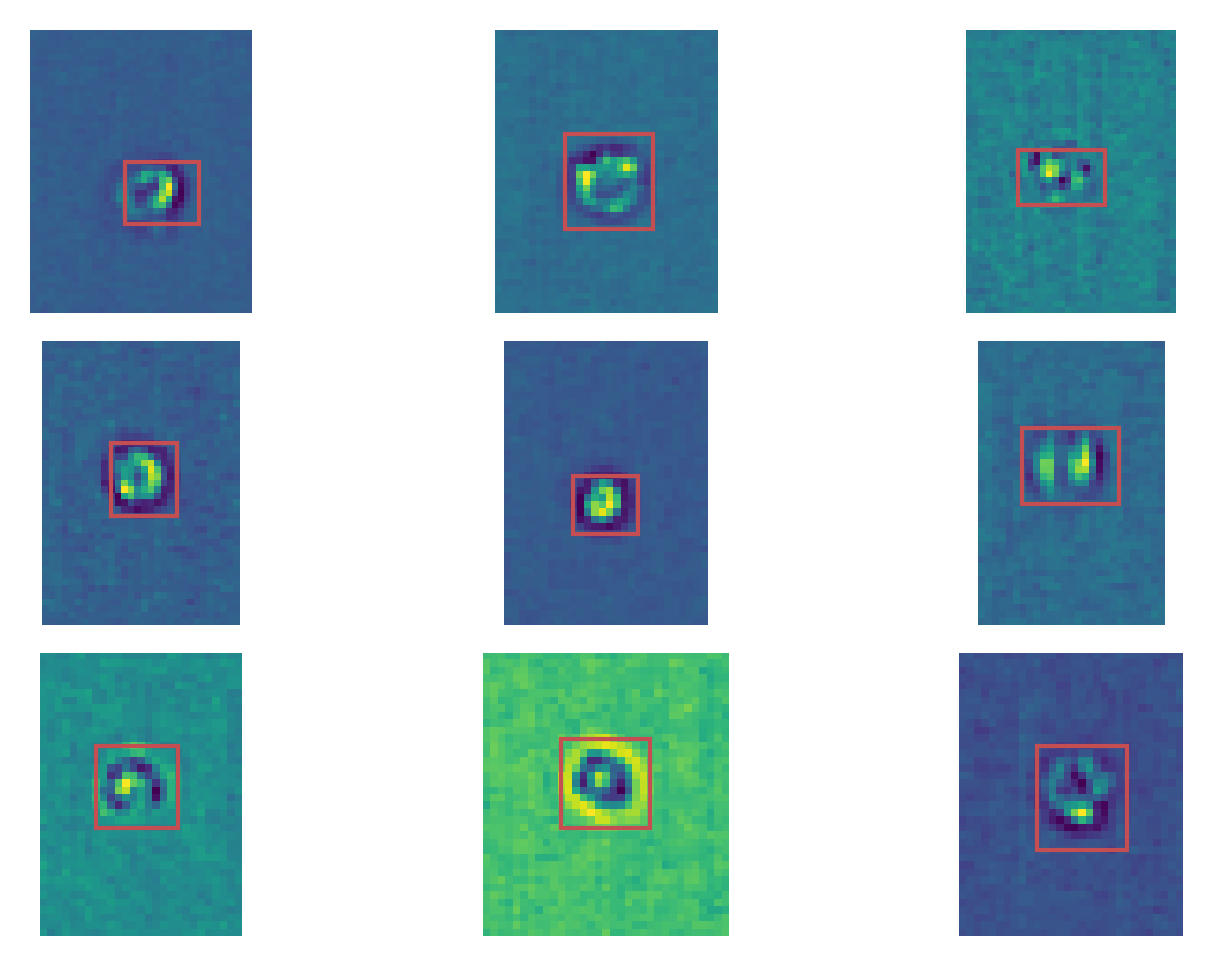

In [227]:
from matplotlib import patches
# fig, axes = plt.subplots(3, 3, dpi=300, gridspec_kw=dict(wspace=1, hspace=1), constrained_layout=True)
# axes = axes.ravel()

fig = plt.figure()
spec = fig.add_gridspec(3,3, wspace=0, hspace=0.1)

for (_, row), s in zip(rows.iterrows(), spec):
    ax = fig.add_subplot(s)
    
    minr, minc, maxr, maxc = row.filter(regex="meta_bbox")
    rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr, linewidth=1, edgecolor='r', facecolor='none')
    ax.set_axis_off()
    
    z = zarr.open(row.meta_path)
    img = z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])
    ax.imshow(plt.get_cmap("viridis")(skimage.img_as_ubyte((img[0] - img[0].min()) / (img[0].max() - img[0].min()))))
    ax.add_patch(rect)
plt.savefig("bboxes.png", dpi=300, transparent=True)

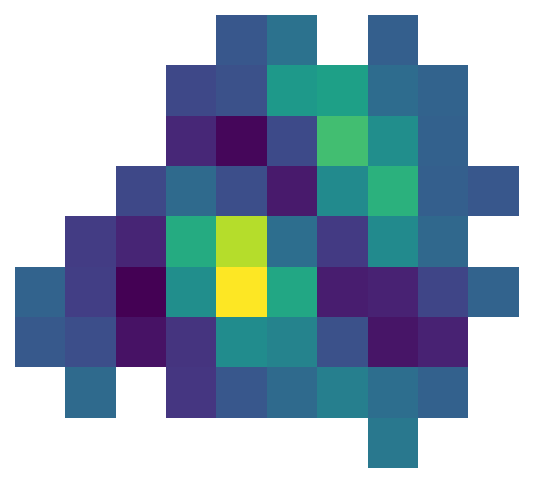

In [129]:
from scip.segmentation import threshold
fig, ax = plt.subplots(dpi=150)
row = rows.iloc[10]

z = zarr.open(row.meta_path)
el = threshold.get_mask(dict(pixels=z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])), main=True, main_channel=0)

minr, minc, maxr, maxc = row.filter(regex="meta_bbox")
img = el["pixels"][0, int(minr):int(maxr), int(minc):int(maxc)]
mask = el["mask"][0, int(minr):int(maxr), int(minc):int(maxc)]

img = skimage.img_as_float(img * mask)
img[mask] = (img[mask] - img[mask].min()) / (img[mask].max() - img[mask].min())
img = plt.get_cmap("viridis")(img)
img[~mask, 3] = 0

ax.imshow(img)
ax.set_axis_off()
plt.savefig("masked_cell.png", dpi=150, transparent=True)

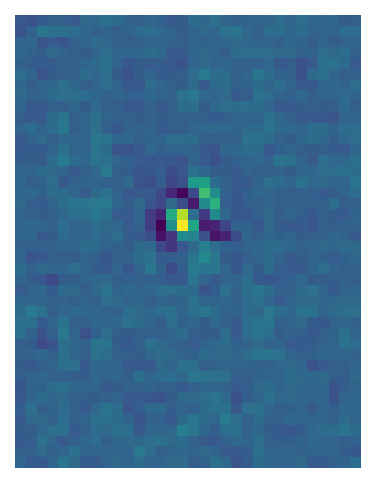

In [132]:
from scip.segmentation import threshold
fig, ax = plt.subplots(dpi=150)
row = rows.iloc[10]

z = zarr.open(row.meta_path)
img = z[row.meta_zarr_idx].reshape(z.attrs["shape"][row.meta_zarr_idx])[0]

img = skimage.img_as_float(img)
img = (img - img.min()) / (img.max() - img.min())
img = plt.get_cmap("viridis")(img)

ax.imshow(img)
ax.set_axis_off()
plt.savefig("cell2.png", dpi=150, transparent=True)

# Predicting IDEAS manual gates from all fluorescence intensity features

This is a baseline sanity check. Training metrics should all be very high, since the manual gates have been set on the fluorescence intensity features using relatively simple rules.

In [24]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df

In [25]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

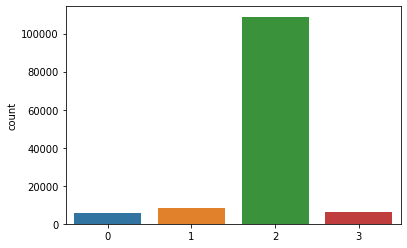

In [26]:
seaborn.countplot(x=y)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    3.3s remaining:    2.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.5s finished


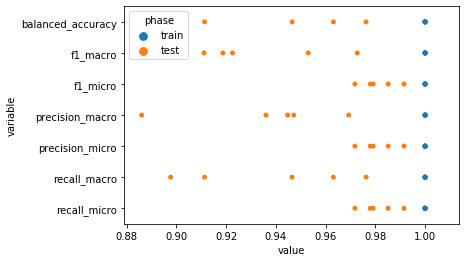

In [29]:
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="scip_feat_combined_bgcorr.*sum.*"), y, 
    model
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.0s finished


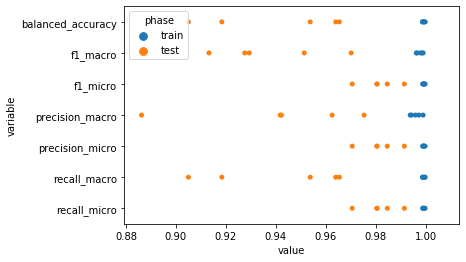

In [30]:
from sklearn import tree
model = tree.DecisionTreeClassifier(class_weight="balanced")
_ = predict_gates(
    df.filter(regex="ideas_feat_intensity_m.*"), y, 
    model
)

# QC plots of control and infected samples

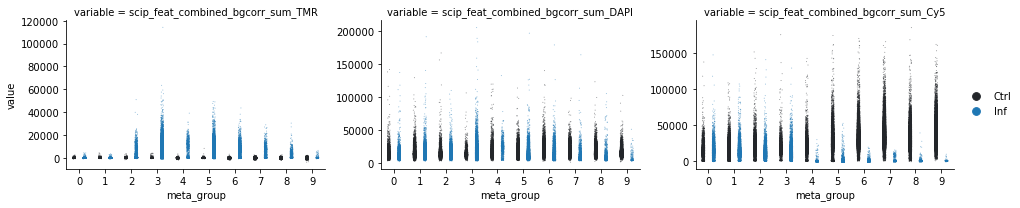

In [25]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_combined_bgcorr_sum_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

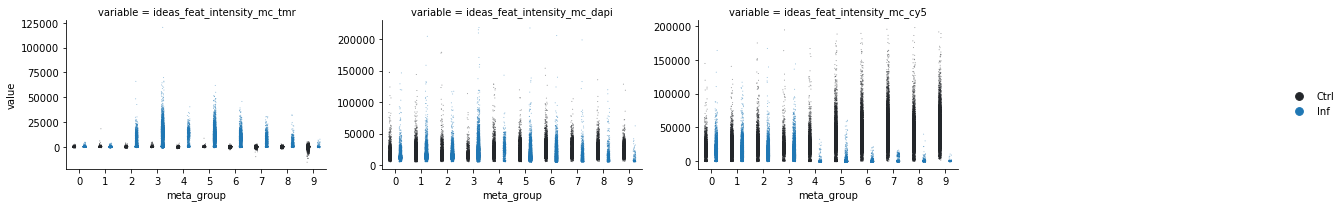

In [27]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="ideas_feat_intensity_mc_(tmr|dapi|cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

## Logicle transform

In [28]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[[
        "scip_feat_combined_bgcorr_sum_TMR", 
        "scip_feat_combined_bgcorr_sum_DAPI", 
        "scip_feat_combined_bgcorr_sum_Cy5"
    ]]
    transf = flowutils.transforms.logicle(gdf.values, w=1, t=200000, m=4.5, channel_indices=None)
    df.loc[(slice(None), slice(None), k, slice(None)), [
        "scip_feat_combined_bgcorr_sum_logicle_TMR", 
        "scip_feat_combined_bgcorr_sum_logicle_DAPI", 
        "scip_feat_combined_bgcorr_sum_logicle_Cy5"
    ]] = transf

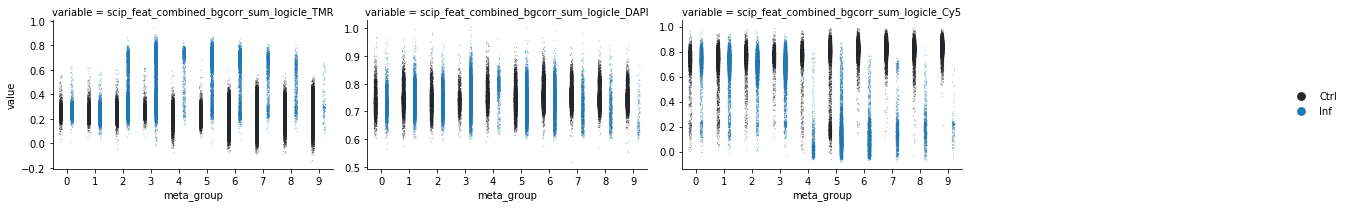

In [29]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_combined_bgcorr_sum_logicle_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

# Feature correlation analysis

In [43]:
X = df.loc[:, :, :, "Inf"].filter(regex="scip_feat")
enc = LabelEncoder().fit(df["meta_label"])
enc.fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])

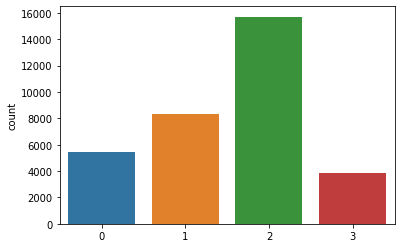

In [44]:
seaborn.countplot(x=y)

In [45]:
cols = df.filter(regex="scip_feat").columns.values

In [46]:
v = VarianceThreshold().fit(X)
X = v.transform(X)

In [47]:
cols = cols[v.get_support()]

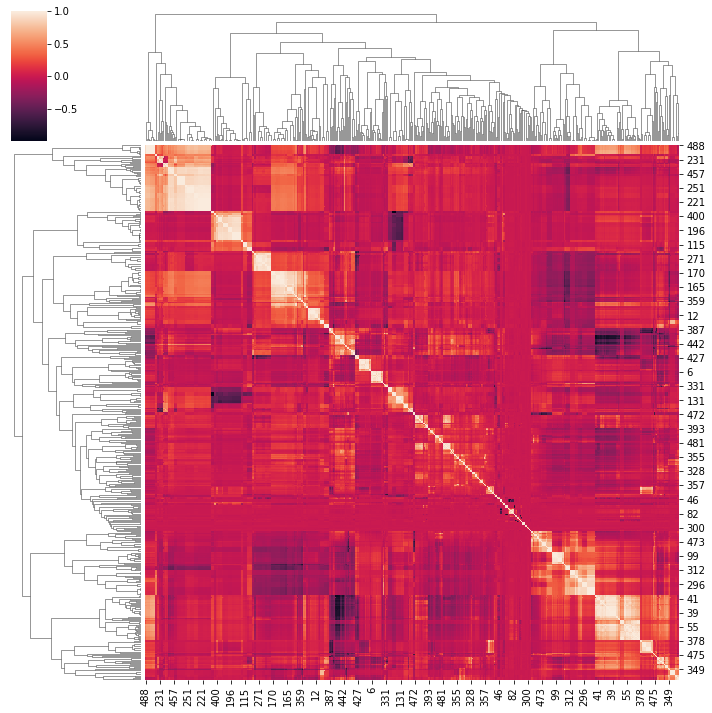

In [48]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

In [49]:
class Correlation(BaseEstimator, TransformerMixin):
    def __init__(self, thresh):
        self.thresh = thresh
    
    def fit(self, X, y=None, **kwargs):
        correlation = numpy.corrcoef(X, rowvar=False)
        var = X.var(axis=1)
        drop = set()
        for i in range(correlation.shape[0]):
            for j in range(i):
                if abs(correlation[i, j]) > self.thresh:
                    if var[i] >= var[j]:
                        c = i
                    else:
                        c = j
                    drop.add(c)
                    
        self.drop = list(drop)
        return self
        
    def transform(self, X, axis=1):
        return numpy.delete(X, self.drop, axis=axis)

In [50]:
corr = Correlation(0.9).fit(X)
X = corr.transform(X)
X.shape

(33318, 176)

In [51]:
cols = corr.transform(cols, axis=0)
len(cols)

176

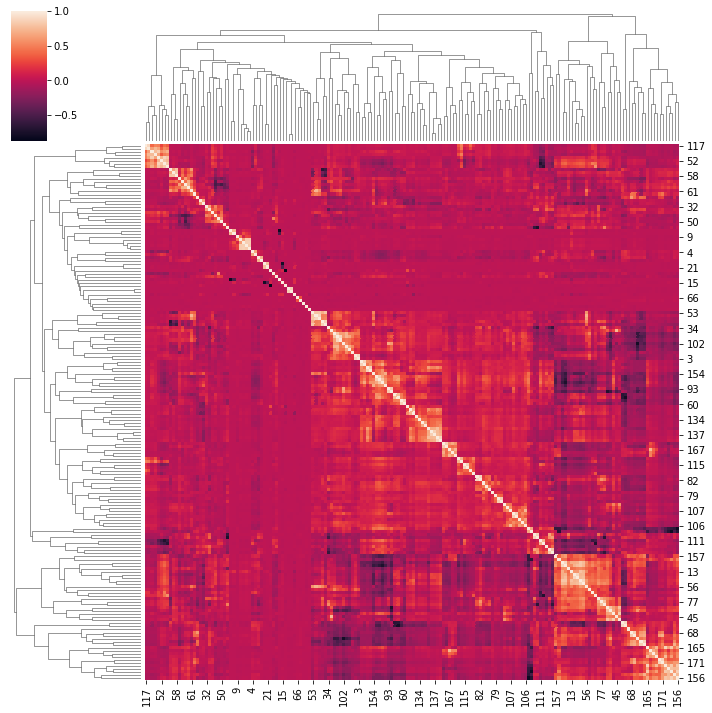

In [52]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

# Prediction of cell states based on all channels except MCP and PSBA channel

We don't use features derived from channel indices 1, 2 and 6 (which correspond to TMR and PSBA)

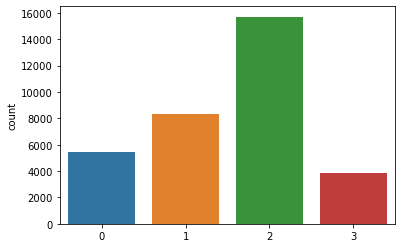

In [30]:
enc = LabelEncoder().fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])
seaborn.countplot(x=y)

In [31]:
to_keep = df.filter(regex=".*scip.*(BF1|DAPI|SSC)$").columns
Xs = df.loc[:, :, :, "Inf"][to_keep]
Xs.shape

(33318, 409)

In [32]:
to_keep = df.filter(regex=".*ideas.*(m01|bf|m06|ch06|m07|dapi).*").columns
to_keep = numpy.array([f for f in to_keep if not (("tmr" in f) or ("cy5" in f))]) # filter out similarity features with fluorescence channels
Xi = df.loc[:, :, :, "Inf"][to_keep]
Xi.shape

(33318, 144)

## Decision-tree classifier with SCIP and IDEAS features

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   11.0s remaining:   16.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   12.3s finished


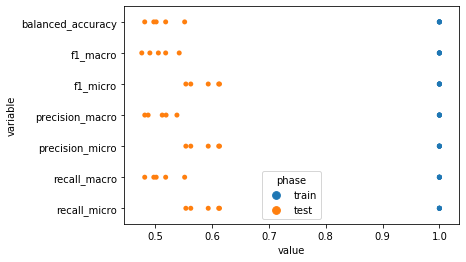

In [74]:
_ = predict_gates(Xs, y, tree.DecisionTreeClassifier(class_weight="balanced"))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.0s finished


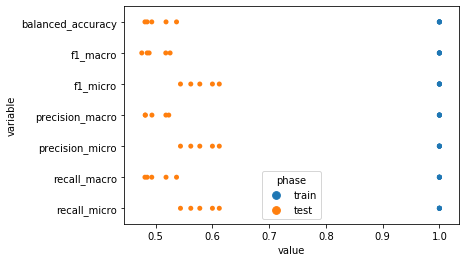

In [95]:
pipeline = make_pipeline(
    VarianceThreshold(),
    Correlation(0.9),
    tree.DecisionTreeClassifier()
)
_ = predict_gates(Xs, y, pipeline)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    7.2s finished


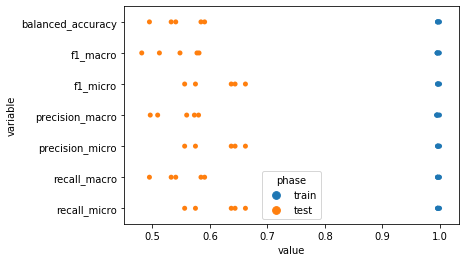

In [96]:
_ = predict_gates(Xi, y, tree.DecisionTreeClassifier())

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    4.5s finished


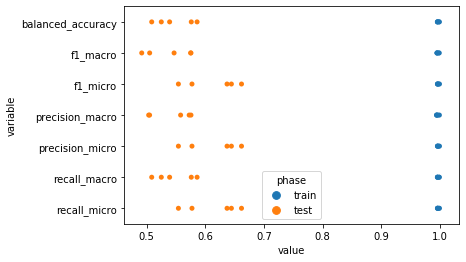

In [97]:
pipeline = make_pipeline(
    VarianceThreshold(),
    Correlation(0.9),
    tree.DecisionTreeClassifier()
)
_ = predict_gates(Xi, y, pipeline)

Two observations from the above plots:
- SCIP and IDEAS features show similar performance with an advantage for IDEAS. This could be due to better masks or better features being computed by IDEAS.
- The decision trees are strongly overfitting on the training data, they would need to be pruned

### Prune decision trees

In [292]:
def fit_with_alpha(alpha, X, y, class_weight=None):
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha, class_weight=class_weight)
    return clf.fit(X, y)

def fit_pruned_dectrees(X, y, class_weight=None, sampler=None, transformer=None):
    
    X_train_orig, X_test_orig, y_train_orig, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
    
    if transformer is not None:
        transformer.fit(X_train_orig)
        X_train_orig = transformer.transform(X_train_orig)
        X_test = transformer.transform(X_test_orig)
    else:
        X_test = X_test_orig
    
    if sampler is not None:
        X_train, y_train = sampler.fit_resample(X_train_orig, y_train_orig)
    else:
        X_train, y_train = X_train_orig, y_train_orig
    
    clf = tree.DecisionTreeClassifier(random_state=0, class_weight=class_weight)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    # subsample alphas
    ccp_alphas = ccp_alphas[::5]
    
    with Pool(processes=64) as pool:
        results = []
        for ccp_alpha in ccp_alphas:
            results.append(pool.apply_async(fit_with_alpha, (ccp_alpha, X_train, y_train, class_weight)))
        
        clfs = []
        for i, res in enumerate(results):
            clfs.append(res.get())
            print("%d/%d" % (i+1, len(results)))
        
    train_scores = [balanced_accuracy_score(clf.predict(X_train), y_train) for clf in clfs]
    test_scores = [balanced_accuracy_score(clf.predict(X_test), y_test) for clf in clfs]
    
    return ccp_alphas, train_scores, test_scores

#### SCIP

In [223]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=0)

In [224]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train)

1/317
2/317
3/317
4/317
5/317
6/317
7/317
8/317
9/317
10/317
11/317
12/317
13/317
14/317
15/317
16/317
17/317
18/317
19/317
20/317
21/317
22/317
23/317
24/317
25/317
26/317
27/317
28/317
29/317
30/317
31/317
32/317
33/317
34/317
35/317
36/317
37/317
38/317
39/317
40/317
41/317
42/317
43/317
44/317
45/317
46/317
47/317
48/317
49/317
50/317
51/317
52/317
53/317
54/317
55/317
56/317
57/317
58/317
59/317
60/317
61/317
62/317
63/317
64/317
65/317
66/317
67/317
68/317
69/317
70/317
71/317
72/317
73/317
74/317
75/317
76/317
77/317
78/317
79/317
80/317
81/317
82/317
83/317
84/317
85/317
86/317
87/317
88/317
89/317
90/317
91/317
92/317
93/317
94/317
95/317
96/317
97/317
98/317
99/317
100/317
101/317
102/317
103/317
104/317
105/317
106/317
107/317
108/317
109/317
110/317
111/317
112/317
113/317
114/317
115/317
116/317
117/317
118/317
119/317
120/317
121/317
122/317
123/317
124/317
125/317
126/317
127/317
128/317
129/317
130/317
131/317
132/317
133/317
134/317
135/317
136/317
137/317
138/317
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true


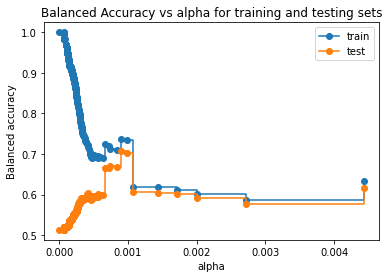

In [225]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [266]:
dectree = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])]
).fit(Xs_train, y_train)
preds = dectree.predict(Xs_train), dectree.predict(Xs_test)

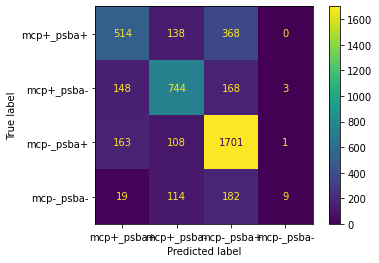

In [267]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

#### IDEAS

In [226]:
Xi_train, Xi_test, y_train, y_test = train_test_split(Xi, y, stratify=y, test_size=0.2, random_state=0)

In [227]:
dectrees_i = fit_pruned_dectrees(Xi_train, y_train)

1/291
2/291
3/291
4/291
5/291
6/291
7/291
8/291
9/291
10/291
11/291
12/291
13/291
14/291
15/291
16/291
17/291
18/291
19/291
20/291
21/291
22/291
23/291
24/291
25/291
26/291
27/291
28/291
29/291
30/291
31/291
32/291
33/291
34/291
35/291
36/291
37/291
38/291
39/291
40/291
41/291
42/291
43/291
44/291
45/291
46/291
47/291
48/291
49/291
50/291
51/291
52/291
53/291
54/291
55/291
56/291
57/291
58/291
59/291
60/291
61/291
62/291
63/291
64/291
65/291
66/291
67/291
68/291
69/291
70/291
71/291
72/291
73/291
74/291
75/291
76/291
77/291
78/291
79/291
80/291
81/291
82/291
83/291
84/291
85/291
86/291
87/291
88/291
89/291
90/291
91/291
92/291
93/291
94/291
95/291
96/291
97/291
98/291
99/291
100/291
101/291
102/291
103/291
104/291
105/291
106/291
107/291
108/291
109/291
110/291
111/291
112/291
113/291
114/291
115/291
116/291
117/291
118/291
119/291
120/291
121/291
122/291
123/291
124/291
125/291
126/291
127/291
128/291
129/291
130/291
131/291
132/291
133/291
134/291
135/291
136/291
137/291
138/291
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true
y_pred contains classes not in y_true


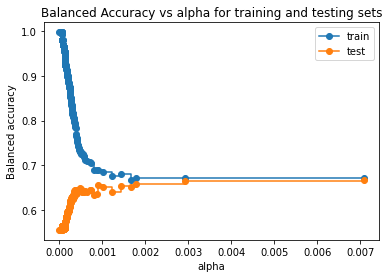

In [228]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_i[0][:-1], dectrees_i[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_i[0][:-1], dectrees_i[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [262]:
rf = RandomForestClassifier(
    n_estimators=500,
    ccp_alpha=dectrees_i[1][numpy.argmax(dectrees_i[3])]
).fit(Xi_train, y_train)
preds = rf.predict(Xi_train), rf.predict(Xi_test)

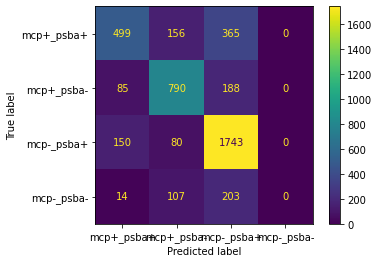

In [263]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

### Dealing with class imbalance through class weighting

In [268]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train, class_weight="balanced")

1/395
2/395
3/395
4/395
5/395
6/395
7/395
8/395
9/395
10/395
11/395
12/395
13/395
14/395
15/395
16/395
17/395
18/395
19/395
20/395
21/395
22/395
23/395
24/395
25/395
26/395
27/395
28/395
29/395
30/395
31/395
32/395
33/395
34/395
35/395
36/395
37/395
38/395
39/395
40/395
41/395
42/395
43/395
44/395
45/395
46/395
47/395
48/395
49/395
50/395
51/395
52/395
53/395
54/395
55/395
56/395
57/395
58/395
59/395
60/395
61/395
62/395
63/395
64/395
65/395
66/395
67/395
68/395
69/395
70/395
71/395
72/395
73/395
74/395
75/395
76/395
77/395
78/395
79/395
80/395
81/395
82/395
83/395
84/395
85/395
86/395
87/395
88/395
89/395
90/395
91/395
92/395
93/395
94/395
95/395
96/395
97/395
98/395
99/395
100/395
101/395
102/395
103/395
104/395
105/395
106/395
107/395
108/395
109/395
110/395
111/395
112/395
113/395
114/395
115/395
116/395
117/395
118/395
119/395
120/395
121/395
122/395
123/395
124/395
125/395
126/395
127/395
128/395
129/395
130/395
131/395
132/395
133/395
134/395
135/395
136/395
137/395
138/395
139/

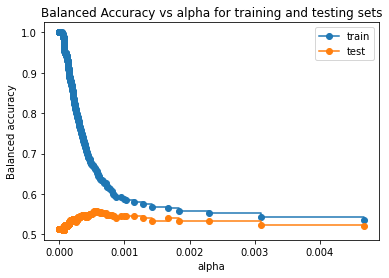

In [269]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [271]:
dectree = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])],
    class_weight="balanced",
    random_state=0
).fit(Xs_train, y_train)
preds = dectree.predict(Xs_train), dectree.predict(Xs_test)

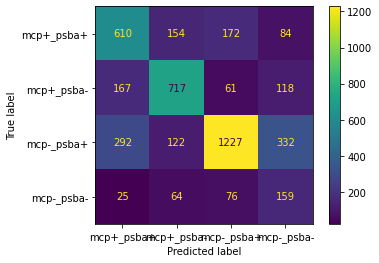

In [272]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

### Dealing with class imbalance through random oversampling

In [275]:
sampler = RandomOverSampler(random_state=0, sampling_strategy="all")

In [276]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train, sampler=sampler)

1/386
2/386
3/386
4/386
5/386
6/386
7/386
8/386
9/386
10/386
11/386
12/386
13/386
14/386
15/386
16/386
17/386
18/386
19/386
20/386
21/386
22/386
23/386
24/386
25/386
26/386
27/386
28/386
29/386
30/386
31/386
32/386
33/386
34/386
35/386
36/386
37/386
38/386
39/386
40/386
41/386
42/386
43/386
44/386
45/386
46/386
47/386
48/386
49/386
50/386
51/386
52/386
53/386
54/386
55/386
56/386
57/386
58/386
59/386
60/386
61/386
62/386
63/386
64/386
65/386
66/386
67/386
68/386
69/386
70/386
71/386
72/386
73/386
74/386
75/386
76/386
77/386
78/386
79/386
80/386
81/386
82/386
83/386
84/386
85/386
86/386
87/386
88/386
89/386
90/386
91/386
92/386
93/386
94/386
95/386
96/386
97/386
98/386
99/386
100/386
101/386
102/386
103/386
104/386
105/386
106/386
107/386
108/386
109/386
110/386
111/386
112/386
113/386
114/386
115/386
116/386
117/386
118/386
119/386
120/386
121/386
122/386
123/386
124/386
125/386
126/386
127/386
128/386
129/386
130/386
131/386
132/386
133/386
134/386
135/386
136/386
137/386
138/386
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true


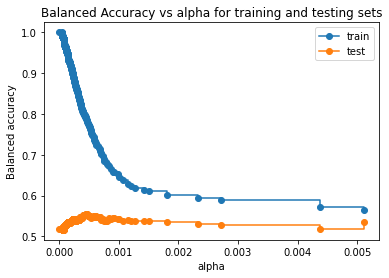

In [277]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [278]:
dectree = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])],
    random_state=0
).fit(*sampler.fit_resample(Xs_train, y_train))
preds = dectree.predict(Xs_train), dectree.predict(Xs_test)

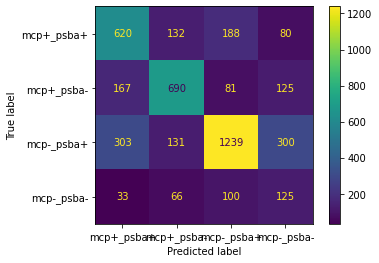

In [279]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

### Dealing with class imbalance through SMOTE

In [499]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=0)

In [501]:
sampler = SMOTE(random_state=0, sampling_strategy="all")

In [502]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train, sampler=sampler)

1/765
2/765
3/765
4/765
5/765
6/765
7/765
8/765
9/765
10/765
11/765
12/765
13/765
14/765
15/765
16/765
17/765
18/765
19/765
20/765
21/765
22/765
23/765
24/765
25/765
26/765
27/765
28/765
29/765
30/765
31/765
32/765
33/765
34/765
35/765
36/765
37/765
38/765
39/765
40/765
41/765
42/765
43/765
44/765
45/765
46/765
47/765
48/765
49/765
50/765
51/765
52/765
53/765
54/765
55/765
56/765
57/765
58/765
59/765
60/765
61/765
62/765
63/765
64/765
65/765
66/765
67/765
68/765
69/765
70/765
71/765
72/765
73/765
74/765
75/765
76/765
77/765
78/765
79/765
80/765
81/765
82/765
83/765
84/765
85/765
86/765
87/765
88/765
89/765
90/765
91/765
92/765
93/765
94/765
95/765
96/765
97/765
98/765
99/765
100/765
101/765
102/765
103/765
104/765
105/765
106/765
107/765
108/765
109/765
110/765
111/765
112/765
113/765
114/765
115/765
116/765
117/765
118/765
119/765
120/765
121/765
122/765
123/765
124/765
125/765
126/765
127/765
128/765
129/765
130/765
131/765
132/765
133/765
134/765
135/765
136/765
137/765
138/765
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true


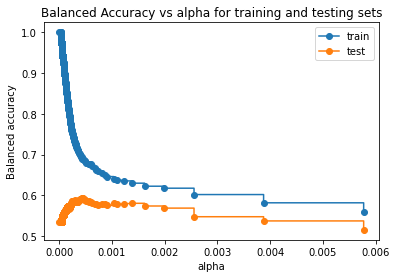

In [503]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [504]:
dectree = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])],
    random_state=0
).fit(*sampler.fit_resample(Xs_train, y_train))
preds = dectree.predict(Xs_train), dectree.predict(Xs_test)

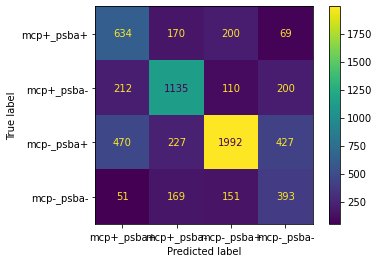

In [505]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

### Dealing with class imbalance through ADASYN oversampling

ADASYN performs neighborhood based oversampling. The neighborhood is determined from the K nearest neighbors. The features are standard scaled to make distances more meaningful.

In [289]:
sampler = ADASYN(random_state=0, sampling_strategy="all")
transformer = StandardScaler()

In [293]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train, sampler=sampler, transformer=transformer)

1/556
2/556
3/556
4/556
5/556
6/556
7/556
8/556
9/556
10/556
11/556
12/556
13/556
14/556
15/556
16/556
17/556
18/556
19/556
20/556
21/556
22/556
23/556
24/556
25/556
26/556
27/556
28/556
29/556
30/556
31/556
32/556
33/556
34/556
35/556
36/556
37/556
38/556
39/556
40/556
41/556
42/556
43/556
44/556
45/556
46/556
47/556
48/556
49/556
50/556
51/556
52/556
53/556
54/556
55/556
56/556
57/556
58/556
59/556
60/556
61/556
62/556
63/556
64/556
65/556
66/556
67/556
68/556
69/556
70/556
71/556
72/556
73/556
74/556
75/556
76/556
77/556
78/556
79/556
80/556
81/556
82/556
83/556
84/556
85/556
86/556
87/556
88/556
89/556
90/556
91/556
92/556
93/556
94/556
95/556
96/556
97/556
98/556
99/556
100/556
101/556
102/556
103/556
104/556
105/556
106/556
107/556
108/556
109/556
110/556
111/556
112/556
113/556
114/556
115/556
116/556
117/556
118/556
119/556
120/556
121/556
122/556
123/556
124/556
125/556
126/556
127/556
128/556
129/556
130/556
131/556
132/556
133/556
134/556
135/556
136/556
137/556
138/556
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true


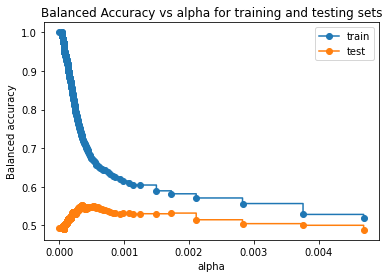

In [294]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [295]:
transformer.fit(Xs_train)
X_scaled = transformer.transform(Xs_train), transformer.transform(Xs_test)
dectree = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])],
    random_state=0
).fit(*sampler.fit_resample(X_scaled[0], y_train))
preds = dectree.predict(X_scaled[0]), dectree.predict(X_scaled[1])

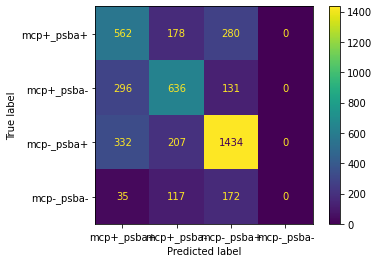

In [296]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

### Refitting without MCP-/PSBA- cells

No methods for alleviating class imbalance issues, seem to lead to good results. Therefore, we will continue on without the least represented class. We will use the class weighting method to deal with the remaining (less severe) class imbalance.

In [477]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs[y!=3], y[y!=3], stratify=y[y!=3], test_size=0.2, random_state=0)

In [478]:
dectrees_s = fit_pruned_dectrees(Xs_train, y_train, class_weight="balanced")

1/370
2/370
3/370
4/370
5/370
6/370
7/370
8/370
9/370
10/370
11/370
12/370
13/370
14/370
15/370
16/370
17/370
18/370
19/370
20/370
21/370
22/370
23/370
24/370
25/370
26/370
27/370
28/370
29/370
30/370
31/370
32/370
33/370
34/370
35/370
36/370
37/370
38/370
39/370
40/370
41/370
42/370
43/370
44/370
45/370
46/370
47/370
48/370
49/370
50/370
51/370
52/370
53/370
54/370
55/370
56/370
57/370
58/370
59/370
60/370
61/370
62/370
63/370
64/370
65/370
66/370
67/370
68/370
69/370
70/370
71/370
72/370
73/370
74/370
75/370
76/370
77/370
78/370
79/370
80/370
81/370
82/370
83/370
84/370
85/370
86/370
87/370
88/370
89/370
90/370
91/370
92/370
93/370
94/370
95/370
96/370
97/370
98/370
99/370
100/370
101/370
102/370
103/370
104/370
105/370
106/370
107/370
108/370
109/370
110/370
111/370
112/370
113/370
114/370
115/370
116/370
117/370
118/370
119/370
120/370
121/370
122/370
123/370
124/370
125/370
126/370
127/370
128/370
129/370
130/370
131/370
132/370
133/370
134/370
135/370
136/370
137/370
138/370
139/

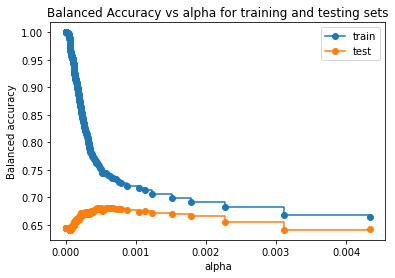

In [479]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_s[0][:-1], dectrees_s[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_s[0][:-1], dectrees_s[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [480]:
dectree_s = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_s[0][numpy.argmax(dectrees_s[2])],
    class_weight="balanced",
    random_state=0
).fit(Xs_train, y_train)
preds = dectree_s.predict(Xs_train), dectree_s.predict(Xs_test)

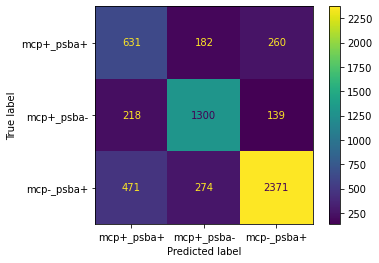

In [481]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

In [482]:
Xi_train, Xi_test, y_train, y_test = train_test_split(Xi[y!=3], y[y!=3], stratify=y[y!=3], test_size=0.2, random_state=0)

In [487]:
dectrees_i = fit_pruned_dectrees(Xi_train, y_train, class_weight="balanced")

1/306
2/306
3/306
4/306
5/306
6/306
7/306
8/306
9/306
10/306
11/306
12/306
13/306
14/306
15/306
16/306
17/306
18/306
19/306
20/306
21/306
22/306
23/306
24/306
25/306
26/306
27/306
28/306
29/306
30/306
31/306
32/306
33/306
34/306
35/306
36/306
37/306
38/306
39/306
40/306
41/306
42/306
43/306
44/306
45/306
46/306
47/306
48/306
49/306
50/306
51/306
52/306
53/306
54/306
55/306
56/306
57/306
58/306
59/306
60/306
61/306
62/306
63/306
64/306
65/306
66/306
67/306
68/306
69/306
70/306
71/306
72/306
73/306
74/306
75/306
76/306
77/306
78/306
79/306
80/306
81/306
82/306
83/306
84/306
85/306
86/306
87/306
88/306
89/306
90/306
91/306
92/306
93/306
94/306
95/306
96/306
97/306
98/306
99/306
100/306
101/306
102/306
103/306
104/306
105/306
106/306
107/306
108/306
109/306
110/306
111/306
112/306
113/306
114/306
115/306
116/306
117/306
118/306
119/306
120/306
121/306
122/306
123/306
124/306
125/306
126/306
127/306
128/306
129/306
130/306
131/306
132/306
133/306
134/306
135/306
136/306
137/306
138/306
139/

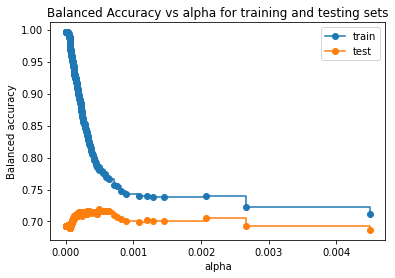

In [488]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Balanced Accuracy vs alpha for training and testing sets")
ax.plot(dectrees_i[0][:-1], dectrees_i[1][:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(dectrees_i[0][:-1], dectrees_i[2][:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [489]:
dectree_i = tree.DecisionTreeClassifier(
    ccp_alpha=dectrees_i[0][numpy.argmax(dectrees_i[2])],
    class_weight="balanced",
    random_state=0
).fit(Xi_train, y_train)
preds = dectree_i.predict(Xi_train), dectree_i.predict(Xi_test)

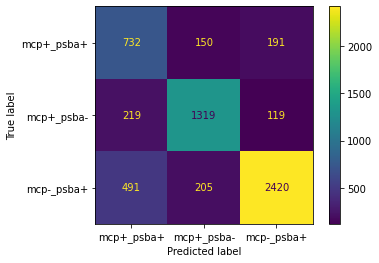

In [490]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds[1]),
    display_labels=enc.classes_
).plot()

#### Analyzing features

In [491]:
ideas_tree = dectree_i
scip_tree = dectree_s

In [492]:
s = numpy.argsort(ideas_tree.feature_importances_)
ideas_features = Xi.columns[s[-20:][::-1]]

In [493]:
s = numpy.argsort(scip_tree.feature_importances_)
scip_features = Xs.columns[s[-20:][::-1]]

In [494]:
pandas.DataFrame(list(zip(ideas_features, scip_features)))

0  \
0             ideas_feat_spot intensity max_m01_bf   
1                     ideas_feat_intensity_mc_dapi   
2           ideas_feat_minor axis intensity_m01_bf   
3   ideas_feat_bright detail intensity r3_m07_dapi   
4                       ideas_feat_circularity_m01   
5            ideas_feat_h variance mean_m07_dapi_5   
6                   ideas_feat_modulation_m07_dapi   
7     ideas_feat_bright detail intensity r7_m01_bf   
8                 ideas_feat_raw mean pixel_m01_bf   
9            ideas_feat_h contrast mean_m07_dapi_5   
10                   ideas_feat_intensity_m06_ch06   
11                    ideas_feat_contrast_m07_dapi   
12               ideas_feat_h energy mean_m01_bf_5   
13                  ideas_feat_gradient rms_m01_bf   
14               ideas_feat_raw max pixel_m07_dapi   
15              ideas_feat_raw median pixel_m01_bf   
16                    ideas_feat_max pixel_mc_dapi   
17      ideas_feat_aspect ratio intensity_m07_dapi   
18                    ideas_feat_mean pixel_m01_bf   
19               ideas_feat_raw min pixel_m07_dapi   

                                        1  
0           scip_feat_minor_axis_length_0  
1             scip_feat_bgcorr_edge_var_4  
2                        scip_feat_mean_0  
3                  scip_feat_bgcorr_sum_0  
4           scip_feat_minor_axis_length_4  
5                    scip_feat_skewness_0  
6                    scip_feat_kurtosis_4  
7                         scip_feat_var_4  
8   scip_feat_bgcorr_glcm_homogeneity_5_0  
9                  scip_feat_bgcorr_sum_4  
10                 scip_feat_bgcorr_max_4  
11            scip_feat_glcm_contrast_3_0  
12                        scip_feat_max_0  
13            scip_feat_bgcorr_kurtosis_0  
14                   scip_feat_edge_var_4  
15          scip_feat_perimeter_crofton_0  
16                   scip_feat_kurtosis_0  
17                 scip_feat_bgcorr_min_3  
18                 scip_feat_bgcorr_mad_0  
19                        scip_feat_min_0

In [495]:
s = numpy.argsort(scip_tree.feature_importances_)
scip_features = Xs.columns[s[::-1]]
scip_features.to_list().index("scip_feat_eccentricity_0")

97

The list above shows the most important features used by the decision tree to make its classification. In the SCIP features we see more basic features like mean, min, minor axis length or skewness. In the IDEAS column, we see more complex features like bright detail intensity, minor axis intensity or circularity. This likely confirms the hypothesis that IDEAS features are currently better. For now I will continue using the SCIP features, while I also work on improving the features

## Hierarchical classification

The above approaches are still not satisfactory. In this section we will try to perform an explicit hierarchical classification by first predicting viral activity and then metabolic activity or vice versa.

In [515]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=0)

In [561]:
from sklearn import base

class Hierarchical(base.BaseEstimator, base.ClassifierMixin):
    def __init__(self, clf):
        if type(clf) is list:
            self.clf_mcp = clf[0]
            self.clf_mcp_neg_psba = clf[1]
            self.clf_mcp_pos_psba = clf[2]
        else:
            self.clf_mcp = base.clone(clf)
            self.clf_mcp_neg_psba = base.clone(clf)
            self.clf_mcp_pos_psba = base.clone(clf)
        
    def fit(self, X, y):
        
        # train mcp pos versus mcp neg
        print("clf 1")
        y_mcp = (y == 0) | (y == 1)
        if type(self.clf_mcp) is tree.DecisionTreeClassifier:
            prune_results = fit_pruned_dectrees(X, y_mcp, class_weight="balanced")
            self.clf_mcp.set_params(**dict(ccp_alpha=prune_results[0][numpy.argmax(prune_results[2])]))
        self.clf_mcp.fit(X, y_mcp)
        
        # train psba | mcp_neg
        print("clf 2")
        y_mcp_neg_psba = y[~y_mcp] == 2
        if type(self.clf_mcp_neg_psba) is tree.DecisionTreeClassifier:
            prune_results = fit_pruned_dectrees(X[~y_mcp], y_mcp_neg_psba, class_weight="balanced")
            self.clf_mcp_neg_psba.set_params(**dict(ccp_alpha=prune_results[0][numpy.argmax(prune_results[2])]))
        self.clf_mcp_neg_psba.fit(X[~y_mcp], y_mcp_neg_psba)
        
        # train psba | mcp_pos
        print("clf 3")
        y_mcp_pos_psba = y[y_mcp] == 0
        if type(self.clf_mcp_pos_psba) is tree.DecisionTreeClassifier:
            prune_results = fit_pruned_dectrees(X[y_mcp], y_mcp_pos_psba, class_weight="balanced")
            self.clf_mcp_pos_psba.set_params(**dict(ccp_alpha=prune_results[0][numpy.argmax(prune_results[2])]))
        self.clf_mcp_pos_psba.fit(X[y_mcp], y_mcp_pos_psba)
        
        return self
    
    def predict(self, X):
        mcp = self.clf_mcp.predict(X)
        return numpy.where(
            mcp,
            numpy.where(self.clf_mcp_pos_psba.predict(X), 0, 1),
            numpy.where(self.clf_mcp_neg_psba.predict(X), 2, 3)
        )

In [530]:
enc.classes_

array(['mcp+_psba+', 'mcp+_psba-', 'mcp-_psba+', 'mcp-_psba-'],
      dtype=object)

### Decision Tree

In [531]:
model = Hierarchical(tree.DecisionTreeClassifier(random_state=0, class_weight="balanced")).fit(Xs_train, y_train)

1/268
2/268
3/268
4/268
5/268
6/268
7/268
8/268
9/268
10/268
11/268
12/268
13/268
14/268
15/268
16/268
17/268
18/268
19/268
20/268
21/268
22/268
23/268
24/268
25/268
26/268
27/268
28/268
29/268
30/268
31/268
32/268
33/268
34/268
35/268
36/268
37/268
38/268
39/268
40/268
41/268
42/268
43/268
44/268
45/268
46/268
47/268
48/268
49/268
50/268
51/268
52/268
53/268
54/268
55/268
56/268
57/268
58/268
59/268
60/268
61/268
62/268
63/268
64/268
65/268
66/268
67/268
68/268
69/268
70/268
71/268
72/268
73/268
74/268
75/268
76/268
77/268
78/268
79/268
80/268
81/268
82/268
83/268
84/268
85/268
86/268
87/268
88/268
89/268
90/268
91/268
92/268
93/268
94/268
95/268
96/268
97/268
98/268
99/268
100/268
101/268
102/268
103/268
104/268
105/268
106/268
107/268
108/268
109/268
110/268
111/268
112/268
113/268
114/268
115/268
116/268
117/268
118/268
119/268
120/268
121/268
122/268
123/268
124/268
125/268
126/268
127/268
128/268
129/268
130/268
131/268
132/268
133/268
134/268
135/268
136/268
137/268
138/268
139/

y_pred contains classes not in y_true
y_pred contains classes not in y_true


In [532]:
preds = model.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.6090584088042975

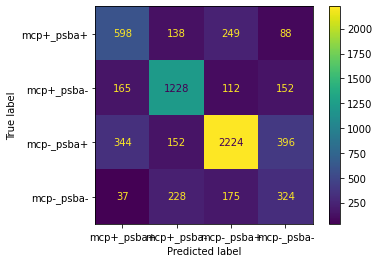

In [533]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds),
    display_labels=enc.classes_
).plot()

In [534]:
model.clf_mcp.ccp_alpha

0.0007133541945080583

In [535]:
model.clf_mcp_neg_psba.ccp_alpha

0.0008970263811412388

In [548]:
model.clf_mcp_pos_psba.ccp_alpha

0.0006418735527580367

### Random Forest

In [550]:
model_rf = Hierarchical(
    [RandomForestClassifier(random_state=0, class_weight="balanced", ccp_alpha=model.clf_mcp.ccp_alpha),
    RandomForestClassifier(random_state=0, class_weight="balanced", ccp_alpha=model.clf_mcp_neg_psba.ccp_alpha),
    RandomForestClassifier(random_state=0, class_weight="balanced", ccp_alpha=model.clf_mcp_pos_psba.ccp_alpha)]
).fit(Xs_train, y_train)

In [551]:
preds = model_rf.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.6213438377337638

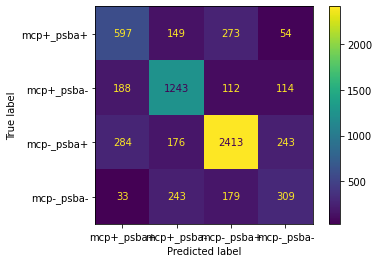

In [552]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds),
    display_labels=enc.classes_
).plot()

### SVC

In [567]:
%%time
model_svc = Hierarchical(
    make_pipeline(
        StandardScaler(),
        SVC(cache_size=2048, class_weight="balanced")
    )
).fit(Xs_train, y_train)

clf 1
clf 2
clf 2
CPU times: user 2min 37s, sys: 2.74 s, total: 2min 39s
Wall time: 2min 39s


In [568]:
preds = model_svc.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.6598389012562977

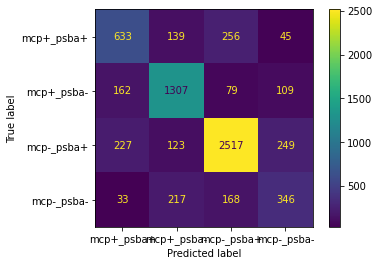

In [569]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, preds),
    display_labels=enc.classes_
).plot()

## SVC classifier for SCIP features

In [33]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=0)

In [34]:
Xi_train, Xi_test, y_train, y_test = train_test_split(Xi, y, stratify=y, test_size=0.2, random_state=0)

In [35]:
df_train, df_test = train_test_split(df.loc[:, :, :, "Inf"], stratify=y, test_size=0.2, random_state=0)

In [36]:
model_svc = make_pipeline(
    StandardScaler(),
    SVC(cache_size=4096, class_weight="balanced")
)

### Tuning C

In [599]:
%%time
scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
grid = GridSearchCV(
    model_svc,
    {
        "svc__C": [0.1, 0.5, 1, 1.5, 2, 2.5]
    },
    refit=False,
    n_jobs=30,
    cv=5,
    scoring=scoring,
    verbose=2,
    return_train_score=True
).fit(
    numpy.ascontiguousarray(Xs_train.values),
    y_train
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 422 ms, sys: 1.53 s, total: 1.95 s
Wall time: 9min 6s


<ErrorbarContainer object of 3 artists>

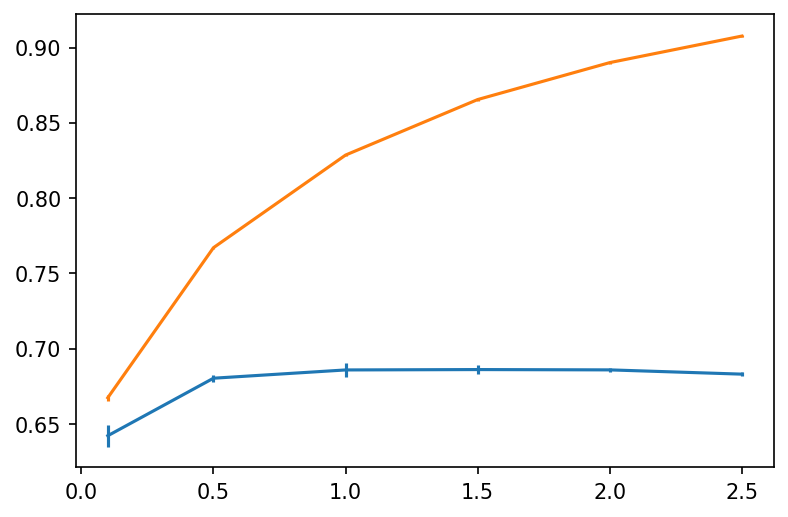

In [603]:
fig, ax = plt.subplots(dpi=150)
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_test_balanced_accuracy"], yerr=grid.cv_results_["std_test_balanced_accuracy"], label="test")
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_train_balanced_accuracy"], yerr=grid.cv_results_["std_train_balanced_accuracy"], label="train")

### Prediction

In [38]:
%%time
model_svc_i = model_svc.fit(Xi_train, y_train)

CPU times: user 1min 31s, sys: 1.96 s, total: 1min 33s
Wall time: 1min 33s


In [39]:
preds_i = model_svc_i.predict(Xi_test)
balanced_accuracy_score(y_test, preds_i)

0.758575570803175

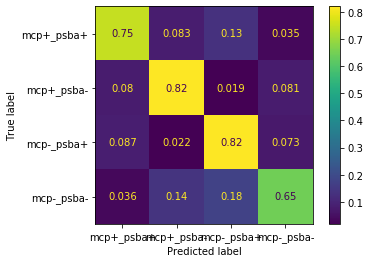

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_i, display_labels=enc.classes_, normalize='true')

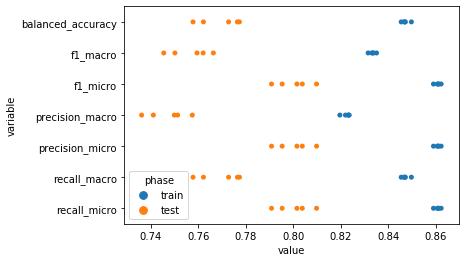

In [41]:
_ = predict_gates(Xs_train, y_train, model_svc)

In [42]:
%%time
model_svc_s = model_svc.fit(Xs_train, y_train)

CPU times: user 3min 31s, sys: 2.06 s, total: 3min 33s
Wall time: 3min 33s


In [43]:
preds_s = model_svc_s.predict(Xs_test)
balanced_accuracy_score(y_test, preds_s)

0.7769870450793412

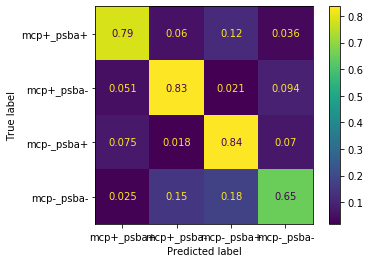

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_s, display_labels=enc.classes_, normalize='true')

### With correlation analysis

In [ ]:
model_svc_corr = make_pipeline(
    VarianceThreshold(),
    Correlation(0.9),
    StandardScaler(),
    SVC(cache_size=4096, class_weight="balanced")
)

In [109]:
%%time
model_svc_corr_i = model_svc_corr.fit(Xi_train, y_train)

CPU times: user 41.9 s, sys: 1.21 s, total: 43.1 s
Wall time: 42.8 s


In [137]:
preds_i = model_svc_corr_i.predict(Xi_test)
balanced_accuracy_score(y_test, preds_i)

NameError: name 'model_svc_corr_i' is not defined

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_i, display_labels=enc.classes_, normalize='true')

In [69]:
%%time
model_svc_corr_s = model_svc_corr.fit(Xs_train, y_train)

CPU times: user 1min 27s, sys: 2.85 s, total: 1min 30s
Wall time: 1min 29s


In [70]:
preds_s = model_svc_corr_s.predict(Xs_test)
balanced_accuracy_score(y_test, preds_s)

0.7244046667259063

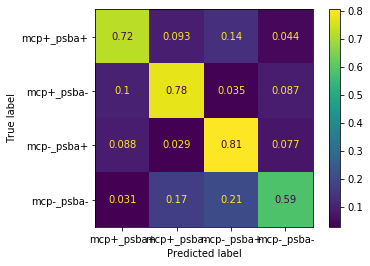

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_s, display_labels=enc.classes_, normalize='true')

### Plot results

In [49]:
enc.inverse_transform(preds_s)

array(['mcp-_psba+', 'mcp+_psba-', 'mcp+_psba-', ..., 'mcp+_psba-',
       'mcp+_psba-', 'mcp-_psba+'], dtype=object)

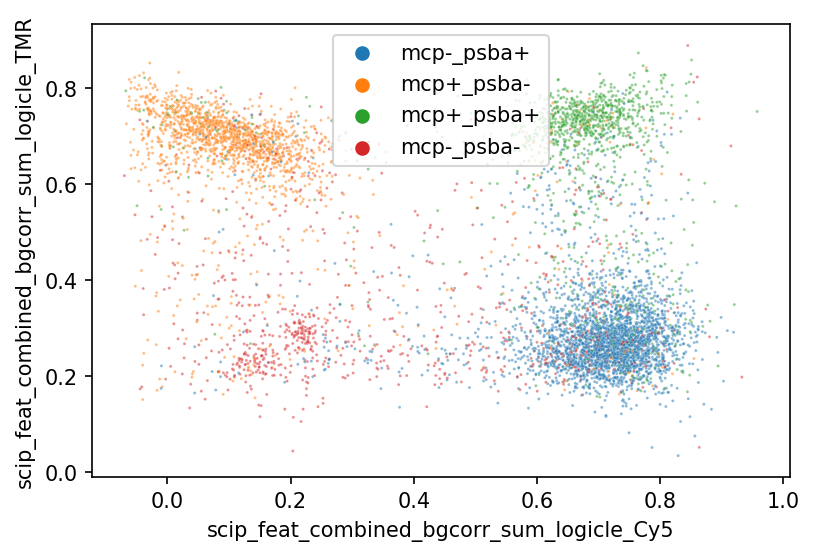

In [50]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    ax=ax,
    data=df_test, 
    x="scip_feat_combined_bgcorr_sum_logicle_Cy5", 
    y="scip_feat_combined_bgcorr_sum_logicle_TMR", 
    hue=enc.inverse_transform(preds_s), s=2, edgecolors="none", alpha=0.5)

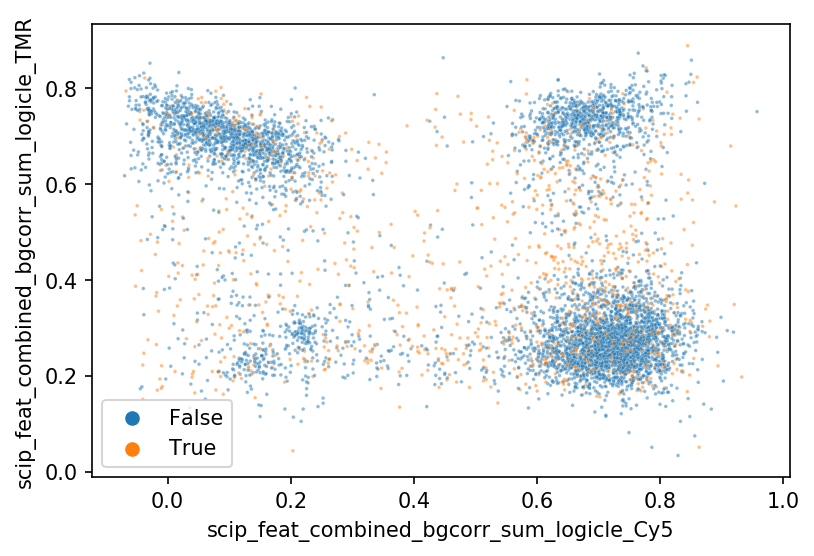

In [51]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    ax=ax,
    data=df_test, 
    x="scip_feat_combined_bgcorr_sum_logicle_Cy5", 
    y="scip_feat_combined_bgcorr_sum_logicle_TMR", 
    hue=preds_s != y_test, s=3, edgecolors="none", alpha=0.5)

## XGB classifier for SCIP features

In [54]:
Xs_train, Xs_test, y_train, y_test =  train_test_split(Xs, y, test_size=0.2, random_state=0)
Xi_train, Xi_test, y_train, y_test =  train_test_split(Xi, y, test_size=0.2, random_state=0)

### Hyper parameter optimization

In [67]:
%%time
scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
grid = RandomizedSearchCV(
    XGBClassifier(
        booster="gbtree", 
        nthread=8, 
        objective="multi:softmax", 
        eval_metric="merror",
        sampling_method="gradient_based",
        tree_method="gpu_hist",
        use_label_encoder=False
    ),
    {
        "eta": [0.1, 0.3, 0.5],
        "max_depth": [3, 6, 10],
        "min_child_weight": [1, 2],
        "subsample": [0.1, 0.3, 0.5, 0.7, 1],
        "colsample_bytree": [0.8, 1],
        "colsample_bylevel": [0.7, 1],
        "colsample_bynode": [0.6, 1]
    },
    n_iter=150,
    refit=False,
    n_jobs=15,
    cv=5,
    scoring=scoring,
    verbose=2
).fit(Xs_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
CPU times: user 3.84 s, sys: 1.44 s, total: 5.28 s
Wall time: 1h 59min 8s


In [69]:
import pickle

In [72]:
with open("grid.pickle", "wb") as fh:
    pickle.dump(grid, fh)

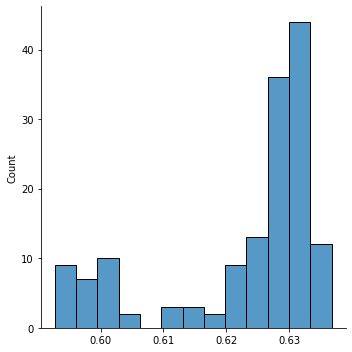

In [79]:
seaborn.displot(x=grid.cv_results_["mean_test_balanced_accuracy"])

In [84]:
best_params = grid.cv_results_["params"][numpy.argmax(grid.cv_results_["mean_test_balanced_accuracy"])]
best_params

{'subsample': 0.7,
 'min_child_weight': 1,
 'max_depth': 10,
 'eta': 0.5,
 'colsample_bytree': 1,
 'colsample_bynode': 1,
 'colsample_bylevel': 0.7}

CPU times: user 3.31 s, sys: 2.54 s, total: 5.85 s
Wall time: 1min 4s


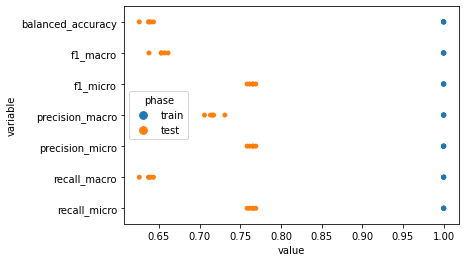

In [85]:
%%time
base = predict_gates(
    Xs_train, y_train,
    XGBClassifier(
        booster="gbtree", 
        nthread=8, 
        objective="multi:softmax", 
        eval_metric="merror",
        sampling_method="gradient_based",
        tree_method="gpu_hist",
        use_label_encoder=False,
        **best_params
    )
)

### Fitting XGBClassifier

In [55]:
model = XGBClassifier(
    booster="gbtree",  
    objective="multi:softmax", 
    eval_metric="merror",
    sampling_method="gradient_based",
    tree_method="gpu_hist",
    use_label_encoder=False,
    n_estimators=500
).fit(Xs_train, y_train)

0.7688562237278015

In [141]:
preds = model.predict(Xs_test)
balanced_accuracy_score(y_test, preds)

0.7688562237278015

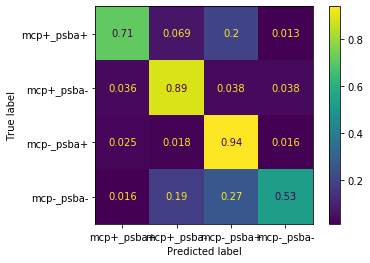

In [142]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=enc.classes_, normalize='true')

### Using the optimal XGB classifier to obtain features of interest

#### Feature importances of the decision trees

In [56]:
s = numpy.argsort(model.feature_importances_)
Xs.columns[s[-5:][::-1]]

Index(['scip_feat_combined_bgcorr_edge_skewness_DAPI',
       'scip_feat_combined_bgcorr_edge_sum_DAPI',
       'scip_feat_combined_sobel_max_DAPI',
       'scip_feat_combined_sobel_min_DAPI',
       'scip_feat_combined_edge_kurtosis_DAPI'],
      dtype='object')

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


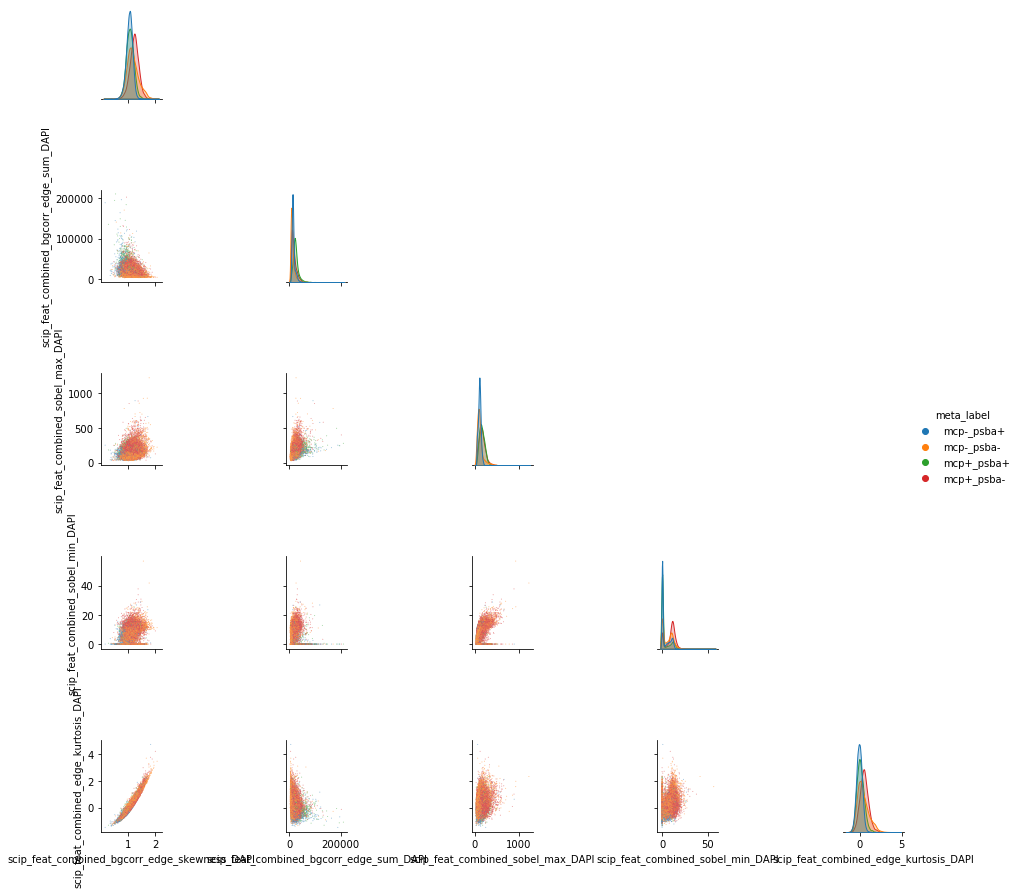

In [59]:
seaborn.pairplot(
    data=df.loc[:, :, :, "Inf"].reset_index(), vars=Xs.columns[s[-5:][::-1]], corner=True,
    hue="meta_label",
    diag_kind="kde",
    plot_kws=dict(s=1, alpha=0.5),
    diag_kws=dict(common_norm=False, common_grid=True)
)

#### SHAP analysis to identify features explaining cell states

In [143]:
Xs_correct = Xs_test[preds == y_test]

In [145]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xs_correct)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


##### MCP-/PSBA+ events

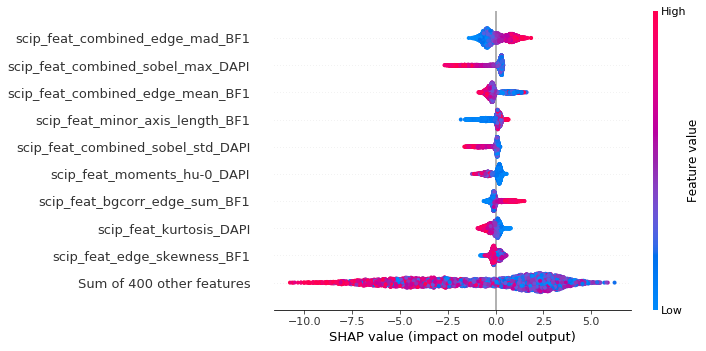

In [146]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

In [147]:
shap.plots.force(shap_values[0, :, enc.transform(["mcp-_psba+"])[0]])

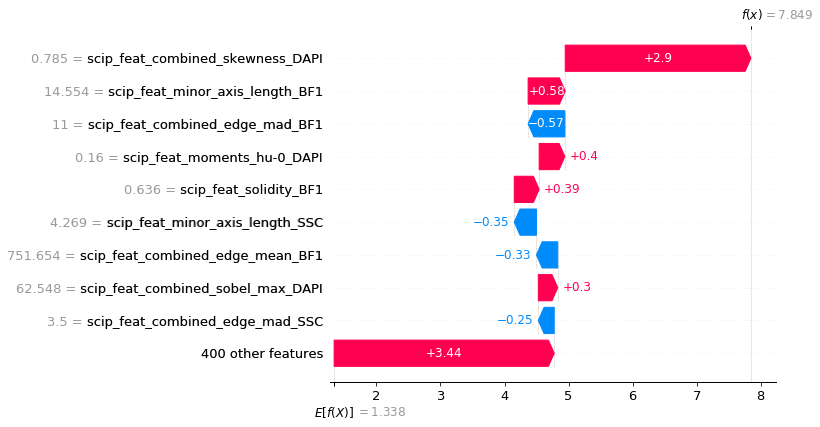

In [148]:
shap.plots.waterfall(shap_values[0, :, enc.transform(["mcp-_psba+"])[0]])

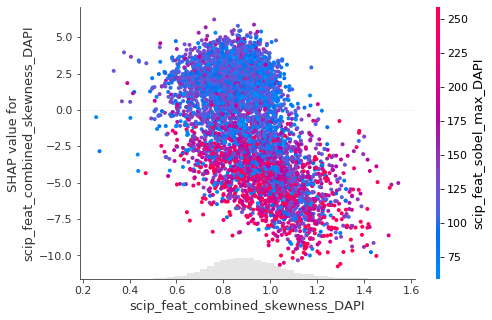

In [149]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_skewness_DAPI", label], color=shap_values[:, :, label])

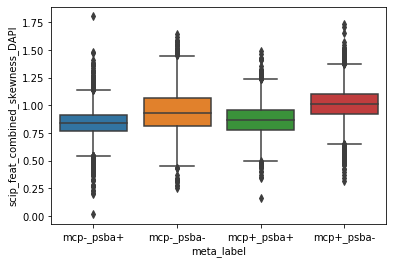

In [150]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_combined_skewness_DAPI")

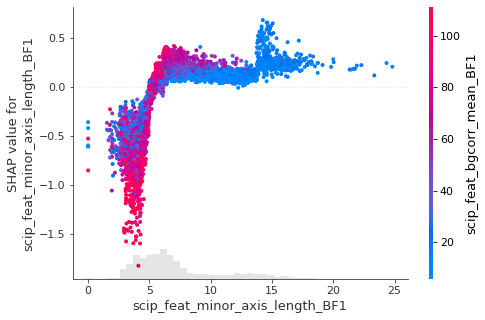

In [151]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_minor_axis_length_BF1", label], color=shap_values[:, :, label])

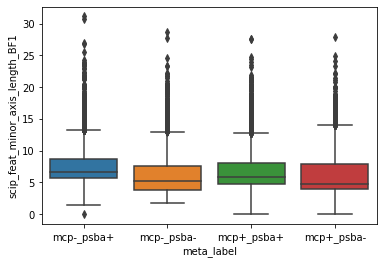

In [152]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_minor_axis_length_BF1")

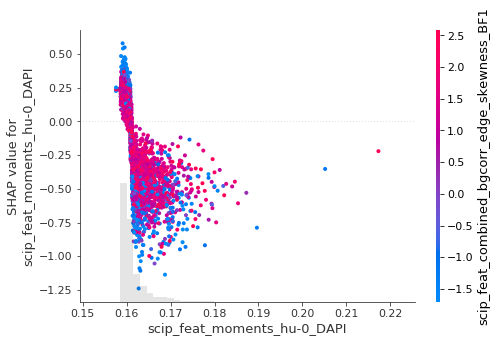

In [153]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_moments_hu-0_DAPI", label], color=shap_values[:, :, label])

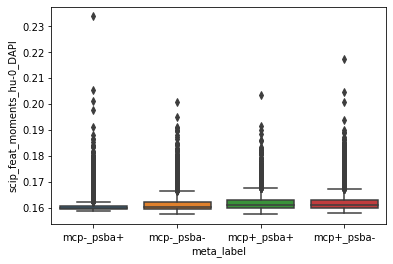

In [154]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_moments_hu-0_DAPI")

#### MCP+/PSBA+ cells

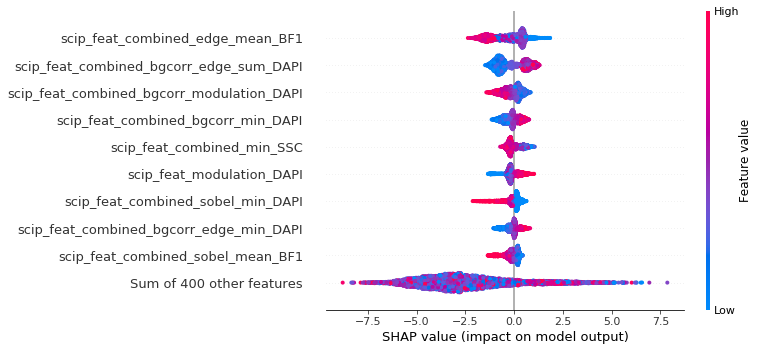

In [155]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

In [156]:
numpy.nonzero(y_test == enc.transform(["mcp+_psba+"])[0])[0]

array([   3,    9,   22, ..., 6617, 6623, 6631])

In [157]:
shap.plots.force(shap_values[3, :, enc.transform(["mcp+_psba+"])[0]])

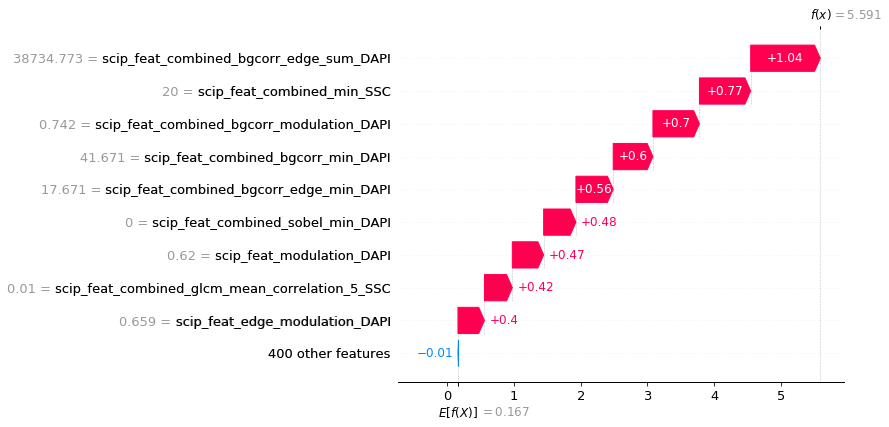

In [158]:
shap.plots.waterfall(shap_values[3, :, enc.transform(["mcp+_psba+"])[0]])

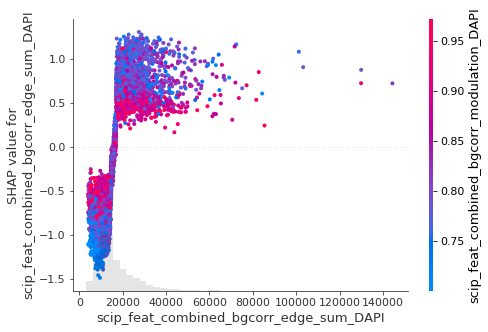

In [159]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_bgcorr_edge_sum_DAPI", label], color=shap_values[:, :, label])

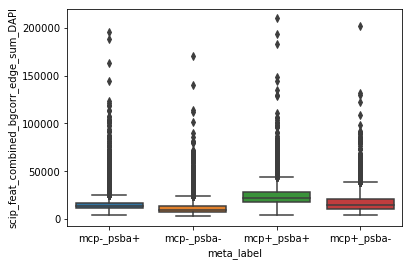

In [160]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_combined_bgcorr_edge_sum_DAPI")

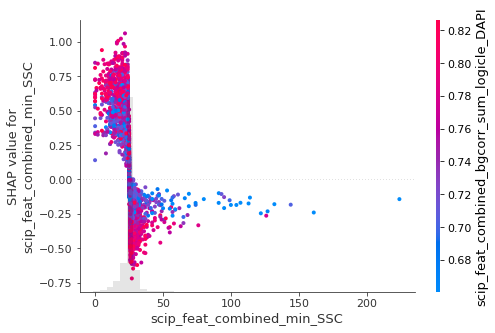

In [162]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_min_SSC", label], color=shap_values[:, :, label])

(0, 100)

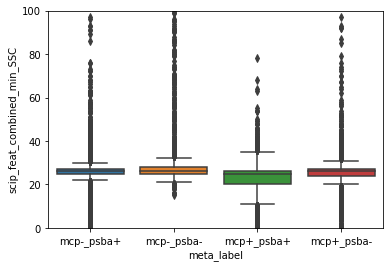

In [175]:
ax = seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_combined_min_SSC")
ax.set_ylim(0, 100)

In [176]:
from scipy.stats import kruskal

In [180]:
groups = [v for _, v in df.loc[:, :, :, "Inf"].groupby("meta_label")["scip_feat_combined_min_SSC"]]
kruskal(*groups)

KruskalResult(statistic=2337.4332847311994, pvalue=0.0)

In [181]:
from scikit_posthocs import posthoc_dunn

In [183]:
posthoc_dunn(groups, p_adjust="bonferroni") < 0.05

1      2      3      4
1  False   True   True   True
2   True  False   True   True
3   True   True  False   True
4   True   True   True  False

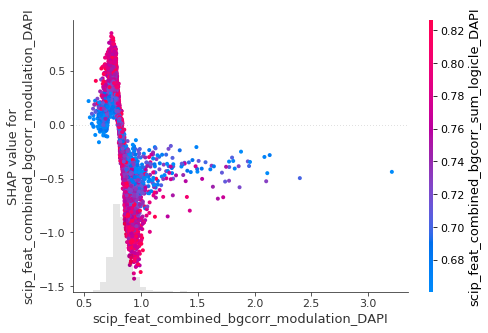

In [164]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_bgcorr_modulation_DAPI", label], color=shap_values[:, :, label])

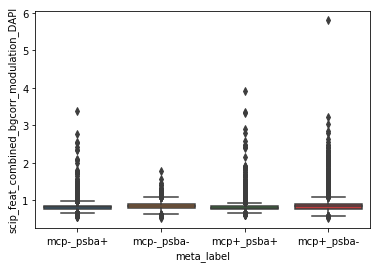

In [165]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_combined_bgcorr_modulation_DAPI")